In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
#from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

C:\Users\USP\anaconda3\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


### Identifying our data limits:

In [2]:
connection_string = 'sqlite:///data/data.db'

In [3]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [4]:
prices.tail(336)

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 01:00:00,278.65,283.80,276.36,283.44,817.668,229274.61550,COMP,ETH
2021-12-01 02:00:00,283.20,283.20,280.61,281.29,254.330,71609.32568,COMP,ETH
2021-12-01 03:00:00,281.25,283.22,279.90,283.09,393.771,110890.74168,COMP,ETH
2021-12-01 04:00:00,283.10,284.16,282.60,283.73,489.120,138532.76788,COMP,ETH
2021-12-01 05:00:00,283.84,284.46,281.95,282.57,185.039,52374.85772,COMP,ETH
...,...,...,...,...,...,...,...,...
2021-12-14 20:00:00,178.99,181.27,178.72,180.28,628.699,113081.48965,COMP,ETH
2021-12-14 21:00:00,180.15,183.76,179.96,183.43,2453.455,444711.90422,COMP,ETH
2021-12-14 22:00:00,183.31,186.74,182.60,185.24,2086.017,386571.01446,COMP,ETH


* The last 2 weeks of our df range from 2021-12-01 to 2021-12-14

In [5]:
print("We have the following tokens in our df: ")

list(dict(prices.groupby("token").size()).keys())

We have the following tokens in our df: 


['AAVE',
 'ADA',
 'ATOM',
 'AVAX',
 'BTC',
 'COMP',
 'CRV',
 'DOT',
 'ETH',
 'SOL',
 'USDT']

In [6]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-12'
connection_string = 'sqlite:///data/data.db'

In [7]:
# Parameters
from_date = "2021-12-03 00:00:00"
to_date = "2021-12-10 00:00:00"
token = "AAVE"
connection_string = "sqlite:///data/data.db"


In [8]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [9]:
prices

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-03 00:00:00,245.824,246.450,244.020,244.974,795.855,194846.640528,AAVE,ETH
2021-12-03 01:00:00,244.707,245.310,243.826,244.361,516.970,126442.701980,AAVE,ETH
2021-12-03 02:00:00,244.200,246.099,244.190,245.126,384.545,94139.444312,AAVE,ETH
2021-12-03 03:00:00,245.225,245.509,240.400,241.454,747.602,181338.765257,AAVE,ETH
2021-12-03 04:00:00,241.395,242.300,239.596,240.266,1052.203,253621.863677,AAVE,ETH
...,...,...,...,...,...,...,...,...
2021-12-09 19:00:00,181.544,182.423,178.274,179.027,3760.579,678661.042412,AAVE,ETH
2021-12-09 20:00:00,179.018,180.292,177.719,177.829,3098.169,555732.359228,AAVE,ETH
2021-12-09 21:00:00,177.594,178.755,176.552,178.380,2360.451,419450.901846,AAVE,ETH


### Functionalities:

#### Returns:

In [10]:
# func for returns:

def ret_ohlc(df):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    # return for each column
    oo = np.log(o/o.shift(1))
    hh = np.log(h/h.shift(1))
    ll = np.log(l/l.shift(1))
    cc = np.log(c/c.shift(1))
    
    return oo, hh, ll, cc


In [11]:
oo, hh, ll, cc = ret_ohlc(prices)

#### Volatility:

In [12]:
# func for volatility:

def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [13]:
prices["return_close"] = cc

#### Maximum Drawdown:

In [14]:
# maximum drawdown

def max_dr():
    x = (1+prices["return_close"]).cumprod()
    previous_peaks = x.cummax()
    drawdown = (x - previous_peaks)/previous_peaks
    
    return drawdown


<AxesSubplot:xlabel='ts'>

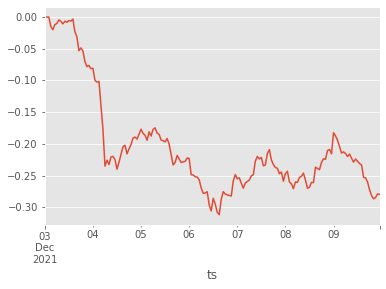

In [15]:
drawdown = max_dr()
drawdown.plot.line()

In [16]:
prices["volatility"] = vol_ohlc(prices)
prices["max_drawdown"] = drawdown

#### Plotting:

In [17]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

In [18]:
# plotting

def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

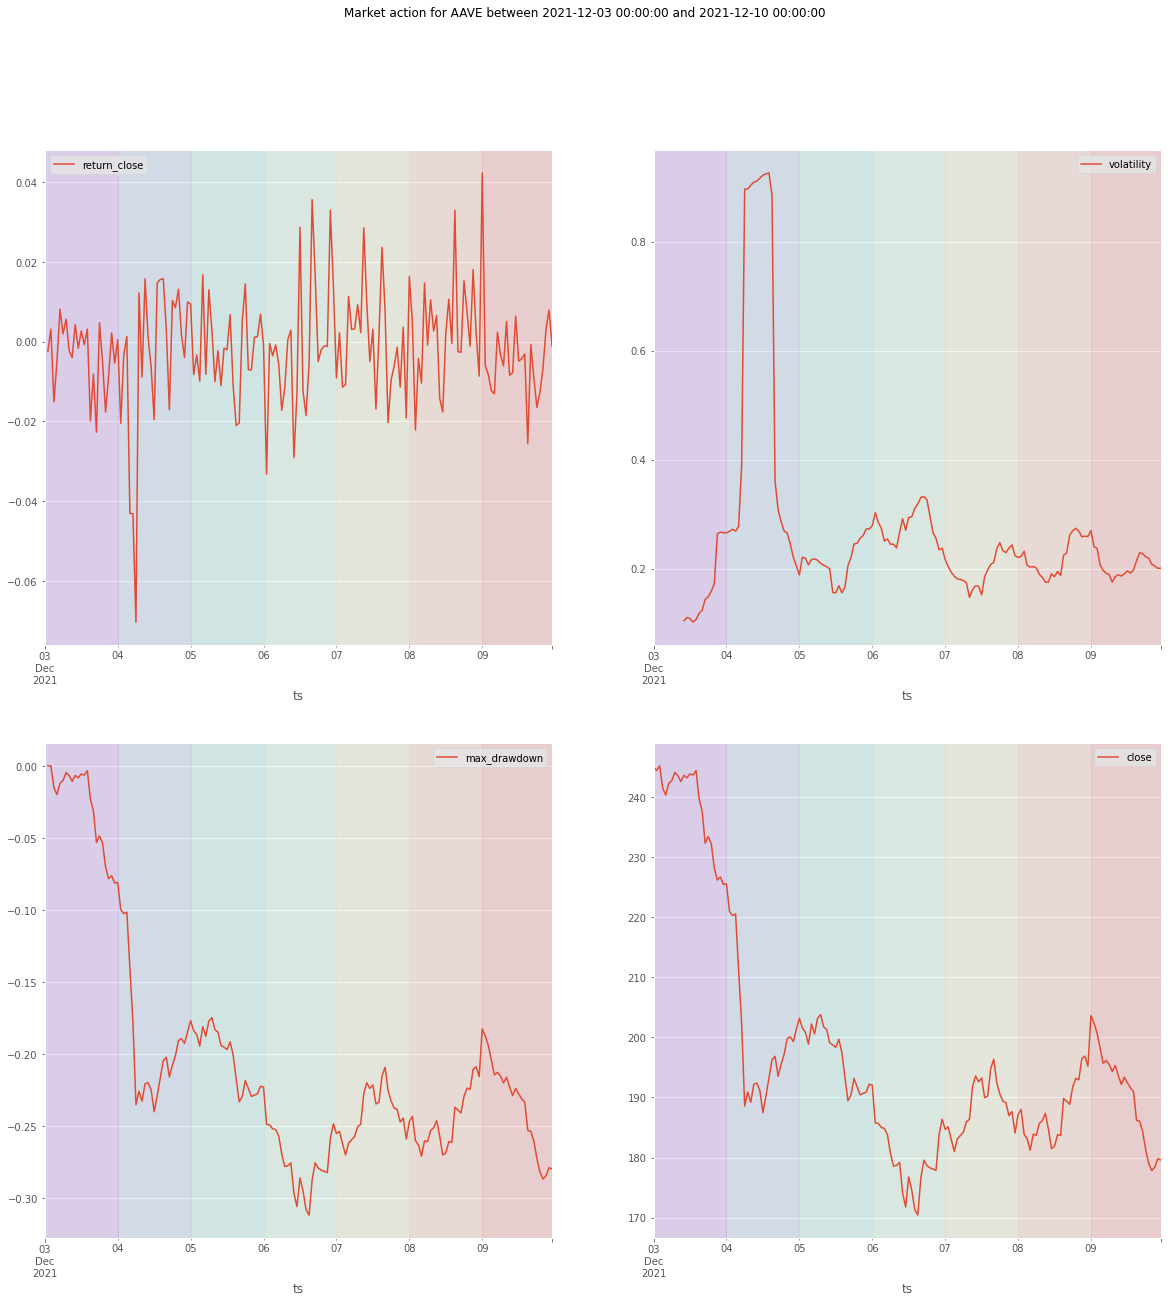

In [19]:
series_plot(prices[['return_close']], ax=ax[0, 0])
series_plot(prices[['volatility']], ax=ax[0, 1])
series_plot(prices[['max_drawdown']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

In [20]:
prices

,open,high,low,close,volume,volumeUSD,token,chain,return_close,volatility,max_drawdown
ts,,,,,,,,,,,
2021-12-03 00:00:00,245.824,246.450,244.020,244.974,795.855,194846.640528,AAVE,ETH,NaN,NaN,NaN
2021-12-03 01:00:00,244.707,245.310,243.826,244.361,516.970,126442.701980,AAVE,ETH,-0.002505,NaN,0.000000
2021-12-03 02:00:00,244.200,246.099,244.190,245.126,384.545,94139.444312,AAVE,ETH,0.003126,NaN,0.000000
2021-12-03 03:00:00,245.225,245.509,240.400,241.454,747.602,181338.765257,AAVE,ETH,-0.015093,NaN,-0.015093
2021-12-03 04:00:00,241.395,242.300,239.596,240.266,1052.203,253621.863677,AAVE,ETH,-0.004932,NaN,-0.019951
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09 19:00:00,181.544,182.423,178.274,179.027,3760.579,678661.042412,AAVE,ETH,-0.012776,0.219343,-0.281865
2021-12-09 20:00:00,179.018,180.292,177.719,177.829,3098.169,555732.359228,AAVE,ETH,-0.006714,0.208118,-0.286687
2021-12-09 21:00:00,177.594,178.755,176.552,178.380,2360.451,419450.901846,AAVE,ETH,0.003094,0.204708,-0.284480


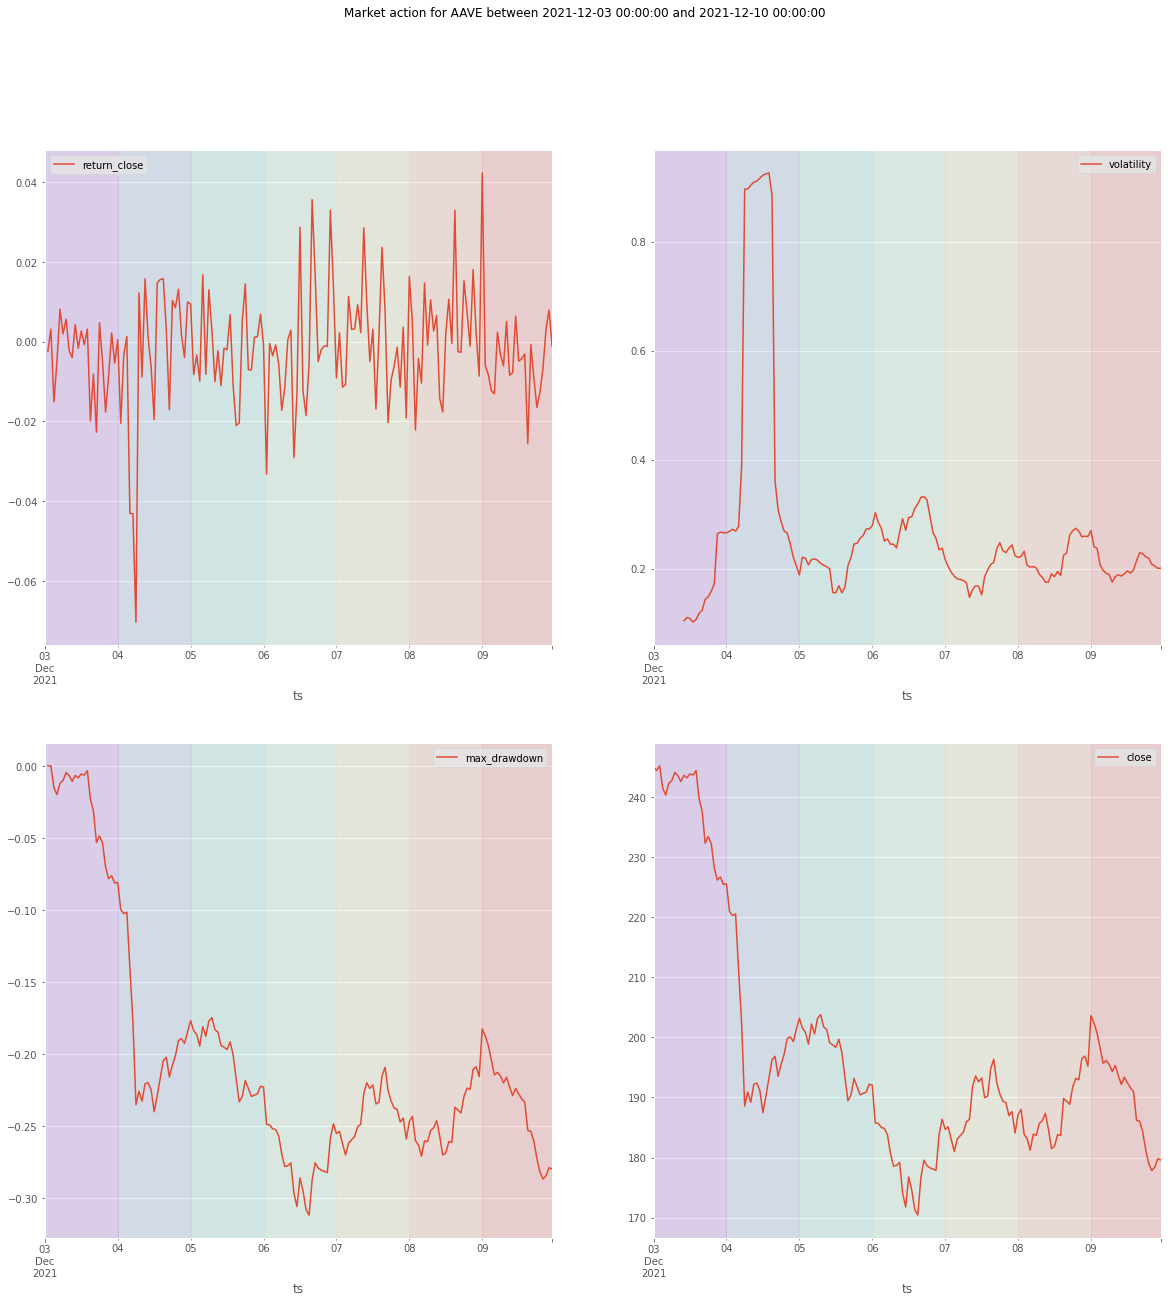

In [21]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)